# Noiseless simulation of the FSL method for non-periodic functions

As we discussed in Sec. (II) of our paper, the FSL method has to be modified for non-periodic functions. In this notebook, we provide a tutorial for using the FSL method to load non-periodic functions. 

We first import useful libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Qiskit 
import qiskit
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.circuit.library import QFT

# Custom libraries
import supplementary
import uniformly_controlled_rotations as UCR

Approximating a non-periodic function by a truncated Fourier series leads to large oscillations near the boundary of the domain, also known as the Gibbs phenomenon. The FSL method loads a Fourier series approximation of the target function on a quantum computer and so we expect large oscillations in the amplitudes of the state prepared using the standard FSL method. To overcome this issue, we proposed the following modification to the FSL method. Instead of directly loading the $n$-qubit target state $|f\rangle \, = \, \sum_{k=0}^{2^{n}-1} \, f_{k} |k\rangle \, $, we consider the $(n+1)$-qubit state

$$ |F\rangle \, = \, \frac{1}{\sqrt{2}} |0\rangle \, \otimes \,\sum_{k=0}^{2^{n}-1} \, f_{k} |k\rangle \, + \, \frac{1}{\sqrt{2}} |1\rangle \, \otimes \,\sum_{k=0}^{2^{n}-1} \, f_{2^{n}-1-k} |k\rangle \, .$$

The amplitudes of this state store the values of the function $F(x) = f(x)/\sqrt{2}$ for $0 \le x \le 1$ and $F(x) = f(2-x)/\sqrt(2)$ for $1 \le x \le 2$. By construction, $F(x)$ is periodic on the domain $[0,2]$, its Fourier series approximation does not suffer from large oscillations. Hence, we can prepare the $(n+1)$-qubit state $|F\rangle$ with high fidelity using the standard FSL method. Once we have prepared the state $|F\rangle$, we pass it through the circuit shown below. This circuit is designed to disentangle the ancilla qubit from the other $n$ qubits and map the state of the $n$ qubits to the target $|f\rangle$. 

<img src="figures/non-periodic_fsl.jpg" alt="FSL circuit for non-periodic functions" style="height: 200px; width:550px;"/>


## Example

As a example, we now perform the simulation of loading $f(x) = \mathcal{N}^{-1/2} \tanh\big(4(x-1/2)\big)$ for $0\le x \le 1$ on a state of $n=20$ qubits using the modified FSL method. The normalization constant $\mathcal{N}$ ensures that the state $|f\rangle$ is normalized. We start by encoding the values of $f(x)$ and $F(x)$ on the `list`s `target_f` and `target_F`, respectively. 

In [2]:
# no. of qubits 
n = 20 
# Discretizing the domain [0,1]
x = [k/(2**n) for k in range(2**n)]

# Target function f
target_f = [np.tanh(4*(xx-0.5)) for xx in x]
target_f = target_f/np.linalg.norm(target_f)

# Target function F
target_F = [*target_f,*target_f[::-1]]
target_F = target_F/np.sqrt(2)

To load $F(x)$ using the FSL method, we first need to approximate it by a truncated Fourier series. We do this using the function `Fourier_state` defined in the code file `supplementary.py`. This function takes the list `target_F` and an `int` $m$ as inputs and returns a `list` of length $2^{(m+1)}$, $[c_{0}, c_{1}, \dots , c_{2^{m}-1}, 0, c_{-2^{m}+1}, \dots, c_{-1} ] \, $, where $c_{\ell}$ are the discrete Fourier coeffiecents of $F(x)$.  

For concreteness, we choose $m=6$.

In [3]:
# No. of Fourier modes
m = 6
# Fourier state |c>
state_c = supplementary.Fourier_state(target_F,m)

Now we can construct the FSL circuit to prepare the state $|F\rangle \, $. Note that this circuit acts on $(n+1)$ qubits. Also, note that we perform the simulation using the Qiskit Aer `statevector_vector` simulator.

In [4]:
# simulator
simulator = Aer.get_backend('statevector_simulator')

# Initialize a quantum circuit
circ = QuantumCircuit(n+1)

# Uniformly controlled rotation
# to prepare the state |c>
U_c = UCR.cascade_UCRs(state_c)

# Apply U_c on the last (m+1) qubits
Uc_qubits = range(n-m,n+1)
circ.compose(U_c,qubits=Uc_qubits,inplace=True)

# Apply a cascade of CNOTs
for i in range(n-m):
    circ.cx(n-m,i)

# Finally, apply the inverse QFT.
inv_qft = QFT(num_qubits=n+1, inverse=True)
inv_qft = transpile(inv_qft, simulator)
circ.compose(inv_qft,qubits=range(n,-1,-1),inplace=True)

Once we have the circuit to prepare the state $|F\rangle \, $, we now apply the CNOT gates to disentangle the ancilla qubit from the other $n$ qubits and to map the state of the $n$ qubits to $|f\rangle \, $. 

In [5]:
# Disentangle the ancilla qubit 
# using a cascade of CNOTs and
# a Hadamard
for i in range(1,n+1):
    circ.cx(0,i)
circ.h(0)

Finally, we run the circuit and plot the simulated statevector. 

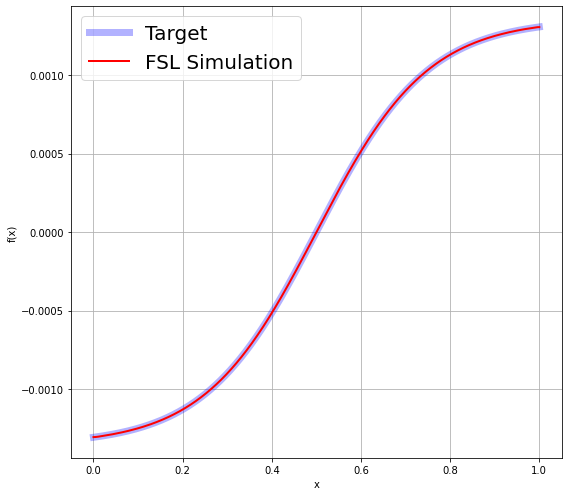

In [6]:
# Run the circuit
# and get the statevector
job = simulator.run(circ)
output_state = job.result().get_statevector(circ)

# Qubit reordering
simulated_f = supplementary.output_reordering(output_state)[:2**n]

# Plottting the simulated statevectors 
fig=plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111)
plt.grid()
line, = ax.plot(x, target_f, 'blue', lw=7, alpha=0.3,label='Target')
line1, = ax.plot(x, np.real(simulated_f), 'red', lw=2,label='FSL Simulation')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend(loc=2,fontsize=20)
plt.tight_layout()
plt.show()

This shows that we can load a non-periodic function on a quantum computer with high fidelity using the FSL method. We also calculate the infidelity, $1 - |\langle f_{FSL} | f_{target} \rangle|^2$, between the target state and the simulated state.

In [7]:
# Calculate infidelity
infidelity = 1 - np.abs(np.dot(np.conjugate(simulated_f),target_f))**2
print(infidelity)

8.033165022069966e-09


## Conclusion

In this notebook, we have reviewed how to load a non-periodic function on a quantum state using the FSL method and have provided a worked example. 